I am currently an analyst that works for the pharmaceutical company called MediHealth Solutions. I was asked to create multiple models that are capable of predicting the likelihood of individuals receiving vaccines for the H1N1 flu as well as the seasonal flu.

# Import necessary libraries and read in data

In [1]:
#Import necessary libraries

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, make_scorer, roc_curve
import matplotlib.pyplot as plt

First step is to read in the data.

In [2]:
features_df = pd.read_csv('training_set_features.csv')

labels_df = pd.read_csv('training_set_labels.csv')


# Data Preprocessing

Next step is to convert categorical variables into dummy variables and ensure that the data is scaled properly while removing/replacing null values as appropriate.

In [3]:
#Create function that scales data and converts categorical variables into dummy variables while removing/replacing null values

def preprocess_features(features_df):
    # Identify column types
    col_types = features_df.columns.to_series().groupby(features_df.dtypes).groups

    # Extract numeric and categorical features
    numerics = list(features_df.select_dtypes(include=['float']).columns)
    categoricals = list(features_df.select_dtypes(include=['object']).columns)

    float_features = features_df[numerics]
    categorical_features = features_df[categoricals]

    # One-hot encode categorical features
    dummies = pd.get_dummies(categorical_features, drop_first=True)

    # Scale numeric features
    float_features_sc_0 = scale(float_features)
    float_features_sc = pd.DataFrame(data=float_features_sc_0, columns=float_features.columns, index=dummies.index)

    # Concatenate scaled numeric features and one-hot encoded categorical features
    features_sc = pd.concat([float_features_sc, dummies], axis=1)

    # Identify missing values
    missing_values = features_sc.isnull().sum()
    missing_value_cols = missing_values[missing_values > 0].index.tolist()

    # Use imputer to replace missing values with the median to avoid outliers
    imputer = SimpleImputer(strategy='median')
    features_sc[missing_value_cols] = imputer.fit_transform(features_sc[missing_value_cols])

    # Replace "<" with "lt" and remove ","
    features_sc.columns = features_sc.columns.str.replace('<', 'lt').str.replace(',', '')

    return features_sc

In [4]:
features_sc = preprocess_features(features_df)

Here, I am verifying that the null values were removed.

In [5]:
features_sc.isnull().values.any()

False

As they were removed successfully, I can now begin creating models.

# Model Building: H1N1 Vaccine

Let's begin creating models to see how we can best predict the likelihood of whether a person received the H1N1 vaccine.

First, let's split the data into training and validation sets.

In [6]:
X = features_sc
Y = labels_df['h1n1_vaccine']

X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=0.3,
                                                  random_state=1)



To start off the model building, let's try and properly tune a set of hyperparameters to create a Logistic Regression model.

In [7]:
log_model = LogisticRegression(max_iter=10000, tol=0.1)

#Define parameter grid for hyperparameter tuning
logistic_param_grid = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1]}

#Define ROC AUC scorer
auc_scorer_log = make_scorer(roc_auc_score)

#Create GridSearchCV object
log_grid_search = GridSearchCV(log_model, logistic_param_grid,
                               scoring = auc_scorer_log)

#Fit model to data
log_grid_search.fit(X_train,Y_train)

best_params_log = log_grid_search.best_params_

print("Best Logistic Regression Hyperparameters:", best_params_log)

Best Logistic Regression Hyperparameters: {'C': 0.1}


According to the print statement, GridSearching found the best value for the hyperparameter C. I will create a new model with this tuned value and assess ROC_AUC score.

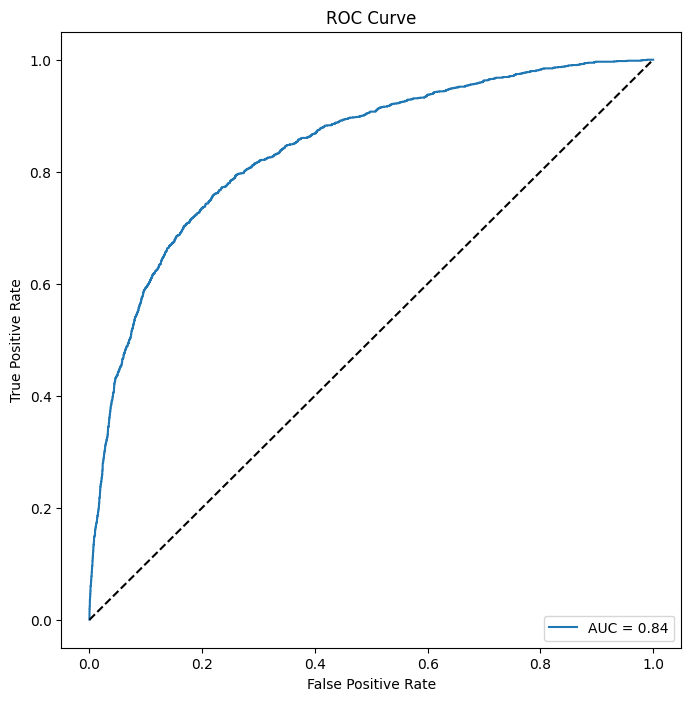

In [8]:
best_logistic_model = LogisticRegression(C=best_params_log['C'], max_iter=10000, tol=0.1).fit(X_train,Y_train)
y_prob_log = best_logistic_model.predict_proba(X_val)[:,1]

fpr_log, tpr_log, thresholds_log = roc_curve(Y_val, y_prob_log)

roc_auc_log = roc_auc_score(Y_val, y_prob_log)

plt.figure(figsize=(8, 8))
plt.plot(fpr_log, tpr_log, label=f'AUC = {roc_auc_log:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

The AUC score of 0.84 indicates that the Logistic Regression can correctly predict individual likelihood of getting the H1N1 vaccine about 84% of the time.

Now, let's try and build a Random Forest Classifier using the same logic.

In [9]:
#Build random forest classifier

rf_classifier = RandomForestClassifier()

#Define parameter grid for hyperparameter tuning

rf_param_grid = {
    'max_depth': [5,10,15,20,25]

}

#Define ROC AUC scorer

auc_score_forest= make_scorer(roc_auc_score)

#Create GridSearchCV object

rf_grid_search = GridSearchCV(rf_classifier, rf_param_grid,
                              scoring=auc_score_forest, n_jobs=-1).fit(X_train,Y_train)
best_params_forest = rf_grid_search.best_params_
print("Best Random Forest Hyperparameters", best_params_forest)

Best Random Forest Hyperparameters {'max_depth': 25}


According to the print statement, GridSearching found the best value for the hyperparameter max_depth. I will create a new model with this tuned value and assess ROC_AUC score.

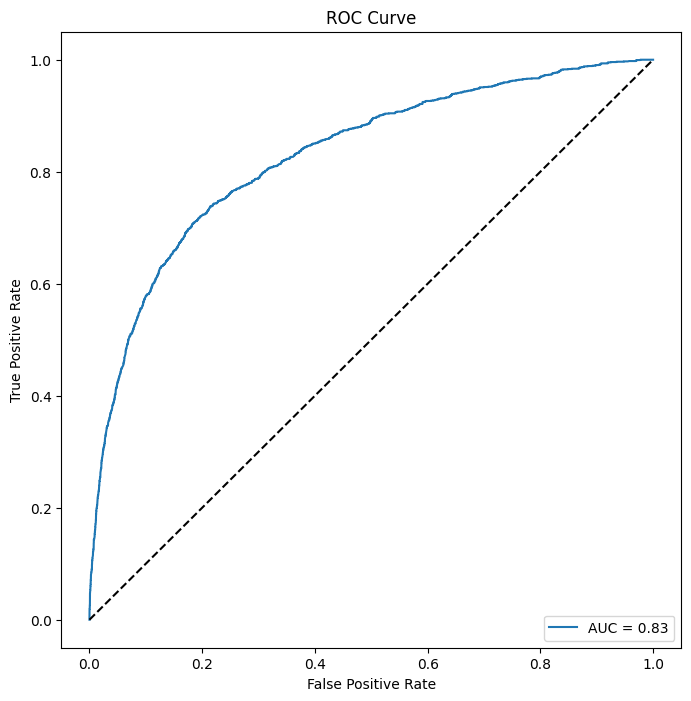

In [10]:
best_forest_model = RandomForestClassifier(max_depth = best_params_forest['max_depth']).fit(X_train,Y_train)
y_prob_for = best_forest_model.predict_proba(X_val)[:,1]

fpr_for, tpr_for, thresholds_for = roc_curve(Y_val, y_prob_for)

roc_auc_for = roc_auc_score(Y_val, y_prob_for)

plt.figure(figsize=(8, 8))
plt.plot(fpr_for, tpr_for, label=f'AUC = {roc_auc_for:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

The AUC score of 0.83 indicates that the Random Forest Classifier can correctly predict individual likelihood of getting the H1N1 vaccine about 83% of the time.

Having done this, I will now create an XGBoosting Algorithm using the same logic as above.

In [11]:
# Create XGBoost classifier

xgb_classifier = XGBClassifier()

#Define parameter grid for hyperparameter tuning

xgb_param_grid = {
    'n_estimators': [200, 400, 600, 800, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
}

#Define ROC AUC scorer

auc_score_xgb= make_scorer(roc_auc_score)

#Create GridSearchCV object

xgb_grid_search = GridSearchCV(xgb_classifier, xgb_param_grid,
                              scoring=auc_score_xgb, n_jobs=-1).fit(X_train,Y_train)
best_params_xgb = xgb_grid_search.best_params_
print("Best XGB Hyperparameters", best_params_xgb)



Best XGB Hyperparameters {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 600}


According to the print statement, GridSearching found the best values for the hyperparameters learning_rate, max_depth, and n_estimators. I will create a new model with these tuned values and assess the ROC_AUC score.

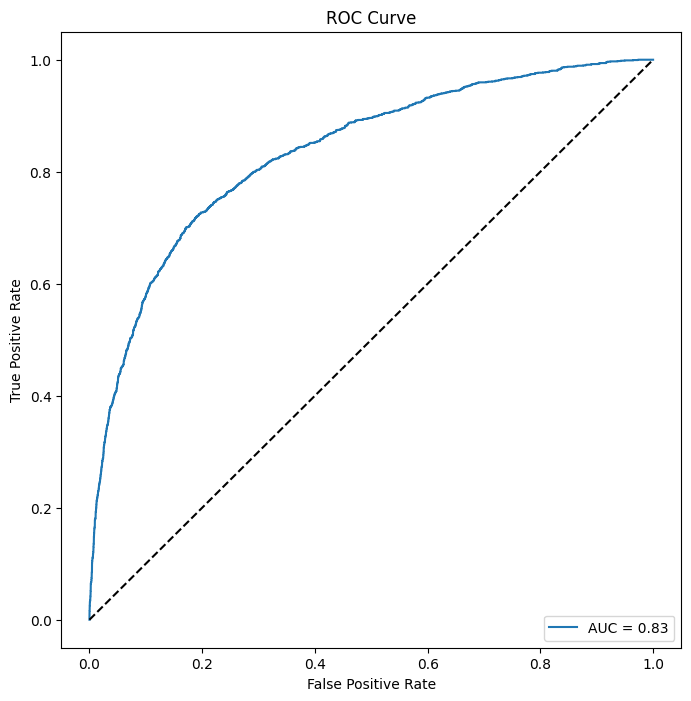

In [12]:
best_xgb_model = XGBClassifier(learning_rate = best_params_xgb['learning_rate'],
                               max_depth= best_params_xgb['max_depth'],
                               n_estimators = best_params_xgb['n_estimators']).fit(X_train,Y_train)
y_prob_xgb = best_xgb_model.predict_proba(X_val)[:,1]

fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(Y_val, y_prob_xgb)

roc_auc_xgb = roc_auc_score(Y_val, y_prob_xgb)

plt.figure(figsize=(8, 8))
plt.plot(fpr_xgb, tpr_xgb, label=f'AUC = {roc_auc_xgb:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

The AUC score of 0.83 indicates that the XGBoosting Classifier can correctly predict individual likelihood of getting the H1N1 vaccine about 83% of the time.

Now that I have built three models with similar success to predict the likelihood of a patient getting an H1N1 Vaccine, I will score them on validation accuracy to see which is the best. 

In [13]:
print("Accuracy of Logistic Regression on Validation Set:", str(best_logistic_model.score(X_val, Y_val)))
print("Accuracy of Random Forest Classifier on Validation Set:", str(best_forest_model.score(X_val, Y_val)))
print("Accuracy of XGB Classifier on Validation Set:", str(best_xgb_model.score(X_val, Y_val)))

Accuracy of Logistic Regression on Validation Set: 0.8426307250717584
Accuracy of Random Forest Classifier on Validation Set: 0.8372644452764259
Accuracy of XGB Classifier on Validation Set: 0.8386372145263946


While all models are close in terms of validation accuracy, we can see that the Logistic Regression model performs ever so slighly better than the other two, so we will use it to make predictions on the test set.

As we have succesfully built several models for the H1N1 Vaccine, let's move on to the Seasonal Vaccine.

# Model Building: Seasonal Vaccine

Prior to beginning creating models to predict the likelihood of receiving the seasonal vaccine, I will first split my dataset into training and validation sets.

In [14]:
#Split data into training and validation sets

X = features_sc
Y = labels_df['seasonal_vaccine']

X_train, X_val, Y_train, Y_val = train_test_split(X,Y, test_size=0.3,
                                                  random_state=1)

Now that this has been completed, I will first create a Decision Tree model. I will follow the same process as above by tuning the hyperparameters via GridSearch.

In [15]:
#Create  decision tree model

tree_classifier = DecisionTreeClassifier()


# Define the parameter grid for tuning
tree_param_grid = {
    'max_depth': [5,10,15,20]
}

#Define ROC AUC scorer

auc_score_tree= make_scorer(roc_auc_score)

tree_grid_search = GridSearchCV(tree_classifier, tree_param_grid, scoring=auc_score_tree, n_jobs=-1).fit(X_train,Y_train)

best_params_tree = tree_grid_search.best_params_
print("Best Decision Tree Hyperparameters", best_params_tree)

Best Decision Tree Hyperparameters {'max_depth': 5}


According to the print statement, GridSearching found the best value for the hyperparameter max_depth. I will create a new model with this tuned value and assess the ROC_AUC score.

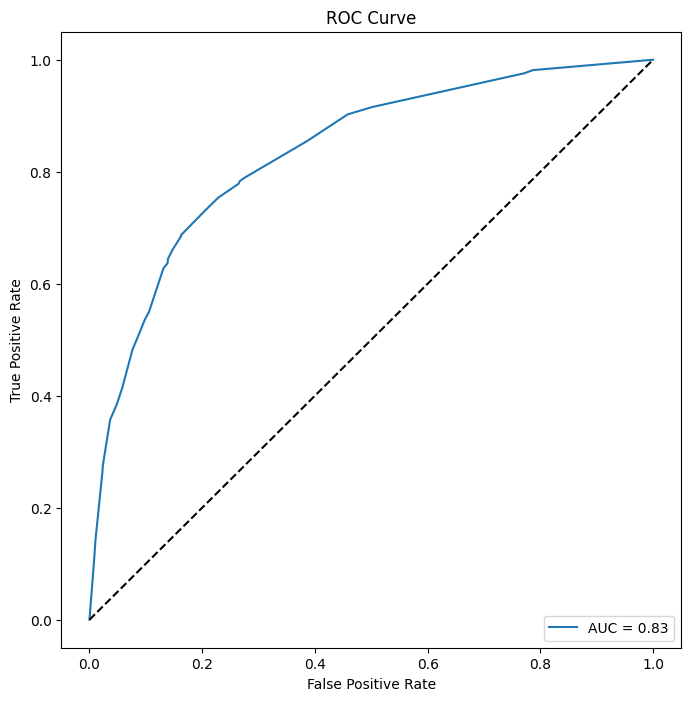

In [16]:
best_tree_classifier = DecisionTreeClassifier(max_depth=best_params_tree['max_depth']).fit(X_train,Y_train)

y_prob_tree = best_tree_classifier.predict_proba(X_val)[:,1]

fpr_tree, tpr_tree, thresholds_tree = roc_curve(Y_val, y_prob_tree)

roc_auc_tree = roc_auc_score(Y_val, y_prob_tree)

plt.figure(figsize=(8, 8))
plt.plot(fpr_tree, tpr_tree, label=f'AUC = {roc_auc_tree:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

The AUC score of 0.83 indicates that the Decision Tree Classifier can correctly predict individual likelihood of getting the seasonal vaccine about 83% of the time.

Seeing as the Decision Tree has been completed, let's create a Gaussian Naive Bayes model following the same tuning steps as above.

In [17]:
#Create a Gaussian Naive Bayes Classifier

gnb_classifier = GaussianNB()

#Define parameter grid for tuning

gnb_param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5] 
}

#Define ROC AUC scorer

auc_score_gnb= make_scorer(roc_auc_score)

#Create grid search object

gnb_grid_search = GridSearchCV(gnb_classifier, gnb_param_grid, scoring = auc_score_gnb, n_jobs=-1).fit(X_train,Y_train)

best_params_gnb = gnb_grid_search.best_params_
print("Best GNB Hyperparameters", best_params_gnb)

Best GNB Hyperparameters {'var_smoothing': 1e-09}


According to the print statement, GridSearching found the best value for the hyperparameter var_smoothing. I will create a new model with this tuned value and assess the ROC_AUC score.

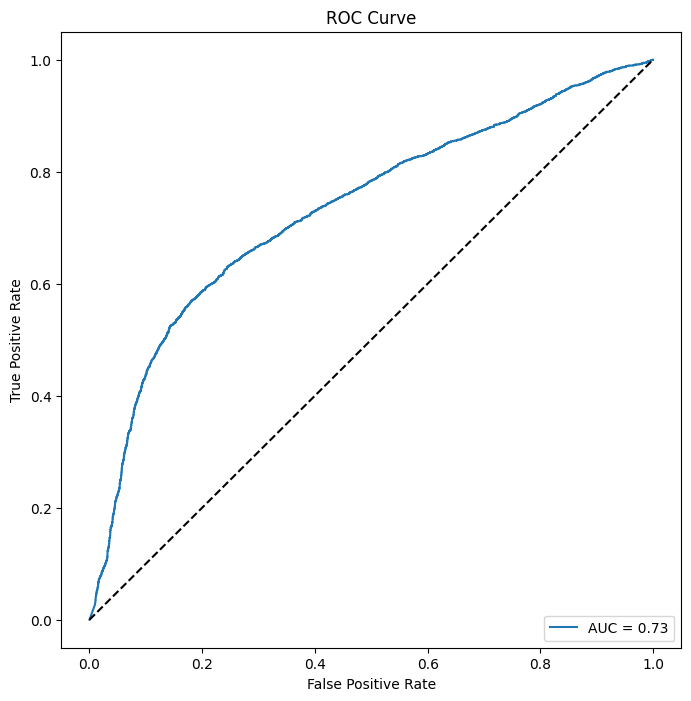

In [18]:
best_gnb_classifier = GaussianNB(var_smoothing = 1e-9).fit(X_train,Y_train)

y_prob_gnb = best_gnb_classifier.predict_proba(X_val)[:,1]

fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(Y_val, y_prob_gnb)

roc_auc_gnb = roc_auc_score(Y_val, y_prob_gnb)

plt.figure(figsize=(8, 8))
plt.plot(fpr_gnb, tpr_gnb, label=f'AUC = {roc_auc_gnb:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

The AUC score of 0.73 indicates that the Gaussian Naive Bayes model can correctly predict individual likelihood of getting the seasonal vaccine about 73% of the time.

The last model I will be building is LightGBM, following the same tuning process as above.

In [19]:
#Create LightGBM Model

lgb_classifier = lgb.LGBMClassifier(num_leaves=50)

#Define parameter grid for grid search

lgb_param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20],
}

#Define ROC AUC scorer

auc_score_lgb= make_scorer(roc_auc_score)

#Create GridSearch object

lgb_grid_search = GridSearchCV(lgb_classifier, lgb_param_grid, scoring = auc_score_lgb, n_jobs=-1).fit(X_train,Y_train)

best_params_lgb = lgb_grid_search.best_params_
print("Best LGB Hyperparameters", best_params_lgb)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8764, number of negative: 9930
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 18694, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.468814 -> initscore=-0.124908
[LightGBM] [Info] Start training from score -0.124908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8764, number of negative: 9930
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 18694, number of used features: 92
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.468814 -> initscore=-0.124908
[LightGBM] [Info] Start training from score -0.124908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

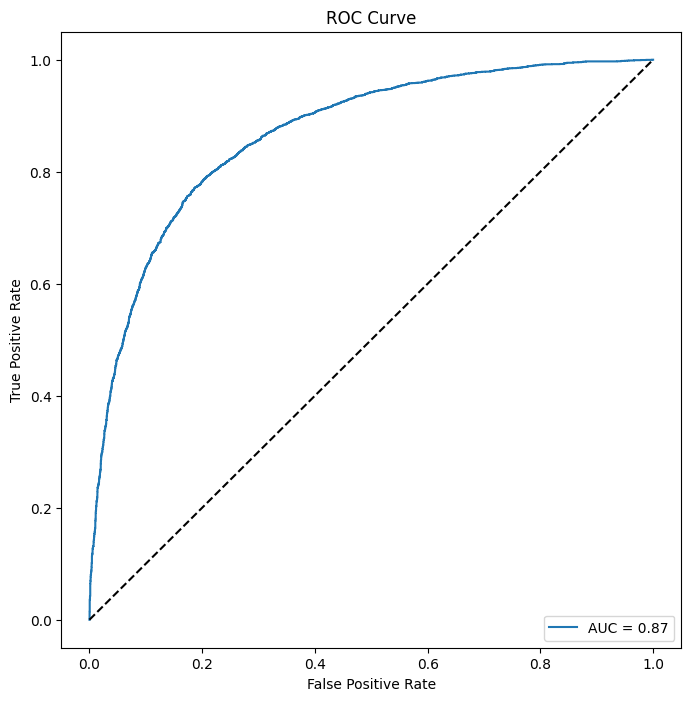

In [20]:
best_lgb_classifier = lgb.LGBMClassifier(learning_rate=best_params_lgb['learning_rate'], 
                                         max_depth=best_params_lgb['max_depth'],
                                         n_estimators=best_params_lgb['n_estimators'],
                                         num_leaves=50).fit(X_train,Y_train)

y_prob_lgb = best_lgb_classifier.predict_proba(X_val)[:,1]

fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(Y_val, y_prob_lgb)

roc_auc_lgb = roc_auc_score(Y_val, y_prob_lgb)

plt.figure(figsize=(8, 8))
plt.plot(fpr_lgb, tpr_lgb, label=f'AUC = {roc_auc_lgb:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

The AUC score of 0.87 indicates that the Light GBM can correctly predict individual likelihood of getting the seasonal vaccine about 87% of the time.

Seeing as I have built three models to predict the likelihood of a patient getting a Seasonal Vaccine, I will score them on validation accuracy to see which is the best. 

In [21]:
print("Accuracy of Decision Tree on Validation Set:", str(best_tree_classifier.score(X_val, Y_val)))
print("Accuracy of Gaussian Naive Bayes on Validation Set:", str(best_gnb_classifier.score(X_val, Y_val)))
print("Accuracy of Light GBM on Validation Set:", str(best_lgb_classifier.score(X_val, Y_val)))

Accuracy of Decision Tree on Validation Set: 0.7685011855734432
Accuracy of Gaussian Naive Bayes on Validation Set: 0.6425808061899414
Accuracy of Light GBM on Validation Set: 0.7939598153001373


Interestingly enough, thess models did not perform as well as the ones that I chose earlier. The Gaussian Naive Bayes classifier did rather poorly on the validation set with a score of 0.64 while the Light GBM and Decision Tree were closer with 0.79 and 0.77 scores respectively. As the LightGBM model performed ever so slightly better, we will be using that for our Seasonal Vaccine likelihood predictions.

# Estimating Probabilities with the Test Data

Now that the main model building is complete, we are going to be using the best models on the test set to predict the likelihood of a patient getting the H1N1 Vaccine and the Seasonal Vaccine respectively.

First step is to load in the test_data and apply the data cleaning steps to make sure it is compatible with our models. I will keep a copy of our respondent id's as they will be used for the final CSV deliverable later.

In [22]:
test_features = pd.read_csv("test_set_features.csv")

respondent_id = test_features['respondent_id']

test_features_processed = preprocess_features(test_features)


After confirming that the test data has been preprocessed and is prepared for our predictions, it is time to predict probabilities for each vaccine.

In [23]:
h1n1_prob_prediction = best_logistic_model.predict_proba(test_features_processed)[:,1]

seasonal_prob_prediction = best_lgb_classifier.predict_proba(test_features_processed)[:,1]

Now that we have our predictions, it is time to put them into a dataframe.

In [24]:
prob_predictions = pd.DataFrame({'respondent_id': respondent_id, 'h1n1_vaccine': h1n1_prob_prediction, 'seasonal_vaccine': seasonal_prob_prediction})

prob_predictions = prob_predictions.reset_index(drop=True)

prob_predictions.to_csv('my_submission.csv', index=False)